In [ ]:
import pandas as pd
import re

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/train.csv", on_bad_lines='skip')  # Replace with your actual file path

# Preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)             # Remove URLs
    text = re.sub(r"@\w+", "", text)                # Remove mentions
    text = re.sub(r"#\w+", "", text)                # Remove hashtags
    text = re.sub(r"[^\w\s']", "", text)            # Remove punctuation except apostrophes
    text = re.sub(r"\d+", "", text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces
    return text

# Apply preprocessing
df['tweet'] = df['tweet'].astype(str).apply(clean_text)

# Features and labels
texts = df['tweet'].values
labels = df['class'].values


In [ ]:
df

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,rt as a woman you shouldn't complain about cle...
1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she start...
3,3,0,2,1,1,rt she look like a tranny
4,6,0,6,0,1,rt the shit you hear about me might be true or...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthafin lie right his tl is trash now...
24779,3,0,1,2,2,you've gone and broke the wrong heart baby and...
24780,3,0,3,0,1,young buck wanna eat dat nigguh like i aint fu...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


**TF-IDF WITH LOGISTIC REGRESSION**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(texts)

# Split data
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_tfidf, labels, test_size=0.2, stratify=labels, random_state=42)

# Logistic Regression with class weight
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_ml, y_train_ml)

# Predict and evaluate
y_pred_ml = clf.predict(X_test_ml)
print("TF-IDF + Logistic Regression with Class Weight:\n", classification_report(y_test_ml, y_pred_ml, digits=4))


TF-IDF + Logistic Regression with Class Weight:
               precision    recall  f1-score   support

           0     0.2957    0.5944    0.3949       286
           1     0.9672    0.8369    0.8973      3838
           2     0.7399    0.9424    0.8289       833

    accuracy                         0.8406      4957
   macro avg     0.6676    0.7912    0.7071      4957
weighted avg     0.8902    0.8406    0.8568      4957



**GLOVE EMBEDDINGS**

In [ ]:
from google.colab import drive
import zipfile
import numpy as np
import os

# Step 2: Extract GloVe File
zip_file_path = '/content/drive/MyDrive/glove.6B.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/glove')




In [ ]:
# Step 3: Load GloVe embeddings
embedding_index = {}
embedding_path = '/content/drive/MyDrive/glove/glove.6B.100d.txt'

with open(embedding_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Check if GloVe is loaded
print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad sequences
maxlen = 50
X = pad_sequences(sequences, maxlen=maxlen)
y = labels


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
import numpy as np

embedding_index = {}
glove_path = "/content/drive/MyDrive/glove/glove.6B.100d.txt"

with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors.")

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector


Loaded 400000 word vectors.


**LSTM WITH BALANCING WEIGHT FOR EACH CLASS**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Compute class weights
import numpy as np
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1,
                    class_weight=class_weight_dict)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 124s 206ms/step - accuracy: 0.5040 - loss: 1.0417 - val_accuracy: 0.7090 - val_loss: 0.8182
Epoch 2/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 126s 177ms/step - accuracy: 0.6783 - loss: 0.8422 - val_accuracy: 0.7504 - val_loss: 0.7188
Epoch 3/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 138s 171ms/step - accuracy: 0.7089 - loss: 0.7733 - val_accuracy: 0.6848 - val_loss: 0.7424
Epoch 4/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 97s 173ms/step - accuracy: 0.7013 - loss: 0.7491 - val_accuracy: 0.7383 - val_loss: 0.6880
Epoch 5/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 105s 187ms/step - accuracy: 0.7189 - loss: 0.7120 - val_accuracy: 0.7711 - val_loss: 0.6211


**Accuracy**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Evaluation Report:\n")
print(classification_report(y_test, y_pred, digits=4))


155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step
Evaluation Report:

              precision    recall  f1-score   support

           0     0.2146    0.5769    0.3128       286
           1     0.9563    0.7866    0.8632      3838
           2     0.6654    0.8235    0.7361       833

    accuracy                         0.7807      4957
   macro avg     0.6121    0.7290    0.6373      4957
weighted avg     0.8646    0.7807    0.8101      4957



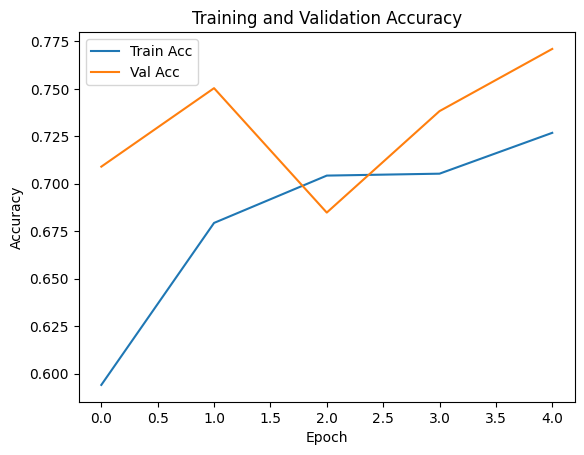

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**RANDOM SAMPLING**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Verify class distribution after resampling
from collections import Counter
print(Counter(y_resampled))


Counter({np.int64(1): 15352, np.int64(2): 15352, np.int64(0): 15352})


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))  # Make GloVe trainable

model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       2,071,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,071,800 (7.90 MB)

 Trainable params: 2,071,800 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_resampled, y_resampled,
                    epochs=15,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[early_stop])


Epoch 1/15
648/648 ━━━━━━━━━━━━━━━━━━━━ 326s 478ms/step - accuracy: 0.6716 - loss: 0.7171 - val_accuracy: 0.9622 - val_loss: 0.1558
Epoch 2/15
648/648 ━━━━━━━━━━━━━━━━━━━━ 312s 482ms/step - accuracy: 0.8873 - loss: 0.3038 - val_accuracy: 0.9748 - val_loss: 0.1181
Epoch 3/15
648/648 ━━━━━━━━━━━━━━━━━━━━ 306s 472ms/step - accuracy: 0.9371 - loss: 0.1800 - val_accuracy: 0.9818 - val_loss: 0.0585
Epoch 4/15
648/648 ━━━━━━━━━━━━━━━━━━━━ 312s 482ms/step - accuracy: 0.9608 - loss: 0.1153 - val_accuracy: 0.9818 - val_loss: 0.0669
Epoch 5/15
648/648 ━━━━━━━━━━━━━━━━━━━━ 316s 473ms/step - accuracy: 0.9735 - loss: 0.0819 - val_accuracy: 0.9870 - val_loss: 0.0481
Epoch 6/15
648/648 ━━━━━━━━━━━━━━━━━━━━ 326s 480ms/step - accuracy: 0.9808 - loss: 0.0590 - val_accuracy: 0.9911 - val_loss: 0.0251
Epoch 7/15
648/648 ━━━━━━━━━━━━━━━━━━━━ 308s 475ms/step - accuracy: 0.9856 - loss: 0.0475 - val_accuracy: 0.9931 - val_loss: 0.0181
Epoch 8/15
648/648 ━━━━━━━━━━━━━━━━━━━━ 311s 480ms/step - accuracy: 0.9885 -

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))


155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step
              precision    recall  f1-score   support

           0     0.3931    0.2378    0.2963       286
           1     0.9184    0.9409    0.9295      3838
           2     0.8134    0.8319    0.8226       833

    accuracy                         0.8820      4957
   macro avg     0.7083    0.6702    0.6828      4957
weighted avg     0.8704    0.8820    0.8750      4957



**External Test Case**

In [ ]:
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove punctuation and numbers
    text = text.lower().strip()
    return text


In [ ]:
def prepare_input(text, tokenizer, maxlen):
    cleaned = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=maxlen)
    return padded


In [ ]:
def predict_class(text, model, tokenizer, maxlen):
    x_input = prepare_input(text, tokenizer, maxlen)
    prediction = model.predict(x_input)
    predicted_class = prediction.argmax(axis=-1)[0]
    return predicted_class


In [ ]:
print("hate" in tokenizer.word_index)  # Should be True


True


155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step


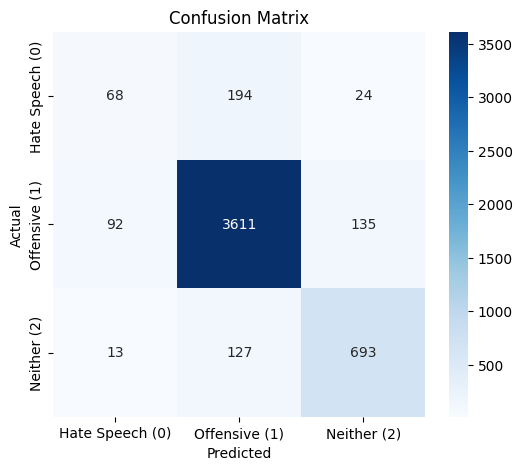

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predicted class labels
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Hate Speech (0)', 'Offensive (1)', 'Neither (2)']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


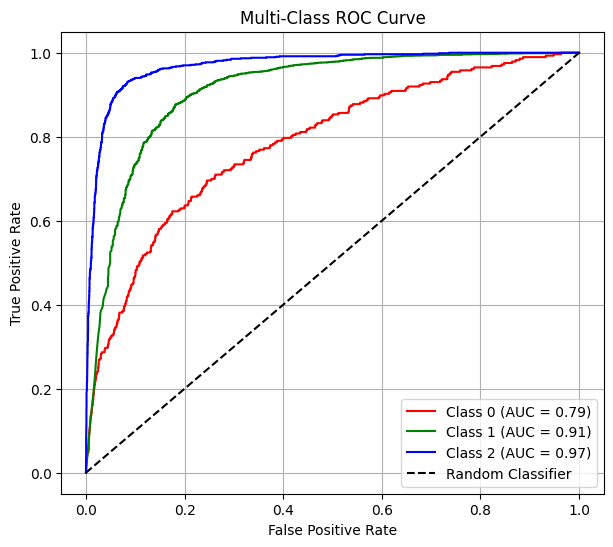

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# Binarize y_test
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(7, 6))
colors = ['red', 'green', 'blue']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
example = "You’re so damn stupid, how do you even function?"
predicted = predict_class(example, model, tokenizer, maxlen)

labels = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}
print("Prediction:", labels[predicted])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Prediction: Offensive Language


**Extra Work to improve accuracy(failure)**

In [ ]:
!pip install imbalanced-learn


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Dense, Dropout, Bidirectional,
                                     Flatten, Activation, RepeatVector, Permute, Multiply, Lambda)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import tensorflow as tf


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train.csv", on_bad_lines='skip')   # Update if needed
df = df[['tweet', 'class']]

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.lower().strip()

df['clean_tweet'] = df['tweet'].apply(clean_text)


In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_tweet'])
sequences = tokenizer.texts_to_sequences(df['clean_tweet'])
word_index = tokenizer.word_index
vocab_size = len(word_index)

max_len = 50
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df['class'].values


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [ ]:
embedding_index = {}
with open("/content/drive/MyDrive/glove/glove.6B.100d.txt", encoding='utf-8') as f:  # Update path if needed
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in word_index.items():
    if i <= vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
def attention_layer(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(inputs.shape[-1])(attention)
    attention = Permute([2, 1])(attention)
    sent_representation = Multiply()([inputs, attention])
    sent_representation = Lambda(lambda xin: tf.reduce_sum(xin, axis=1))(sent_representation)
    return sent_representation


In [ ]:
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_len,
                            trainable=False)(input_layer)
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
att_out = attention_layer(lstm_out)
dense = Dense(64, activation='relu')(att_out)
drop = Dropout(0.5)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 50, 100)        │      2,088,300 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 128)        │         84,480 │ embedding_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 50, 1)          │            129 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 50)             │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 128, 50)        │              0 │ activation[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 50, 128)        │              0 │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 50, 128)        │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128)            │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 3)              │            195 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,181,360 (8.32 MB)

 Trainable params: 93,060 (363.52 KB)

 Non-trainable params: 2,088,300 (7.97 MB)

In [ ]:
#early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_res, y_train_res,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=64,
                    class_weight=class_weights_dict
                    )


Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 108s 159ms/step - accuracy: 0.7335 - loss: 0.5675 - val_accuracy: 0.7813 - val_loss: 0.6299
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 131s 143ms/step - accuracy: 0.7402 - loss: 0.5451 - val_accuracy: 0.8108 - val_loss: 0.5437
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 98s 145ms/step - accuracy: 0.7467 - loss: 0.5314 - val_accuracy: 0.8283 - val_loss: 0.5150
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 99s 147ms/step - accuracy: 0.7597 - loss: 0.5074 - val_accuracy: 0.8138 - val_loss: 0.6061
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 141s 145ms/step - accuracy: 0.7680 - loss: 0.4921 - val_accuracy: 0.8078 - val_loss: 0.5885
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - accuracy: 0.7734 - loss: 0.4728 - val_accuracy: 0.8378 - val_loss: 0.5193
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - accuracy: 0.7836 - loss: 0.4552 - val_accuracy: 0.7979 - val_loss: 0.7088
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 102s 152ms/step - accuracy: 0.7916 - l

194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step

Classification Report:

              precision    recall  f1-score   support

 Hate Speech     0.2162    0.2549    0.2339       357
   Offensive     0.9343    0.8447    0.8873      4798
     Neither     0.6416    0.8857    0.7441      1041

    accuracy                         0.8176      6196
   macro avg     0.5974    0.6618    0.6218      6196
weighted avg     0.8437    0.8176    0.8256      6196



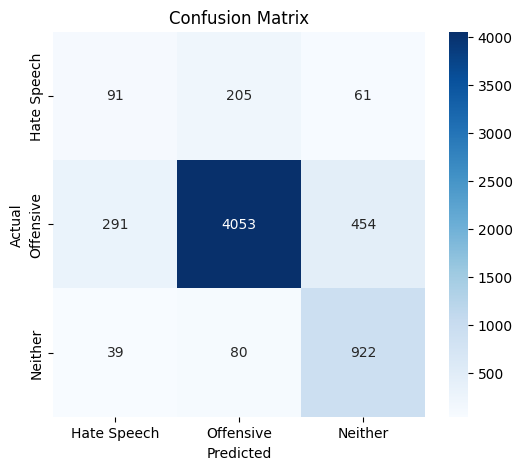

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4, target_names=['Hate Speech', 'Offensive', 'Neither']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate Speech', 'Offensive', 'Neither'],
            yticklabels=['Hate Speech', 'Offensive', 'Neither'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Load your CSV dataset
df = pd.read_csv("/content/drive/MyDrive/train.csv", on_bad_lines='skip') # Replace with your file path
df = df[['tweet', 'class']]

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.lower().strip()

df['clean_tweet'] = df['tweet'].apply(clean_text)

texts = df['clean_tweet'].values
labels = df['class'].values


In [ ]:
vocab_size = 20000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(padded, labels, test_size=0.2, stratify=labels, random_state=42)


In [ ]:
embedding_index = {}
with open("/content/drive/MyDrive/glove/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=max_len,
                        weights=[embedding_matrix],
                        trainable=False))

    model.add(LSTM(units=hp.Int('lstm_units', 64, 256, step=64),
                   dropout=hp.Float('dropout_rate', 0.2, 0.5, step=0.1),
                   recurrent_dropout=hp.Float('recurrent_dropout', 0.2, 0.5, step=0.1)))

    model.add(Dense(3, activation='softmax'))  # 3-class classification

    model.compile(optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:

import keras_tuner as kt
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='glove_lstm_hate_speech'
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(X_train, y_train,
             epochs=10,
             batch_size=64,
             validation_data=(X_val, y_val),
             callbacks=[early_stop])


Trial 8 Complete [00h 11m 48s]
val_accuracy: 0.7742586135864258

Best val_accuracy So Far: 0.7742586135864258
Total elapsed time: 01h 59m 51s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
128               |64                |lstm_units
0.2               |0.4               |dropout_rate
0.3               |0.4               |recurrent_dropout
0.0042013         |0.00036392        |lr

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 136s 415ms/step - accuracy: 0.7629 - loss: 0.7028 - val_accuracy: 0.7743 - val_loss: 0.6671
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 143s 419ms/step - accuracy: 0.7707 - loss: 0.6677 - val_accuracy: 0.7743 - val_loss: 0.6630
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 141s 415ms/step - accuracy: 0.7714 - loss: 0.6712 - val_accuracy: 0.7743 - val_loss: 0.6627
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 130s 418ms/step - accuracy: 0.7751 - loss: 0.6615 - val_accuracy: 0.7743 - val_loss: 0.6631
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 142s 419ms/s